<a href="https://colab.research.google.com/github/eus-lwq/NYUResnetChallenge/blob/dev/qte_nyucifar10challenge_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Citation:


https://colab.research.google.com/github/Rakshit-Shetty/Resnet-Implementation/blob/master/ResNet_Implementation_on_CIFAR10.ipynb

Reference:
https://github.com/kuangliu/pytorch-cifar?tab=readme-ov-file
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385



# CIFAR10 Images Classification with Resnet-18

## Library Import

In [ ]:
!pip install typed-argument-parser

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for typed-argument-parser: filename=typed_argument_parser-1.9.0-py3-none-any.whl size=25615 sha256=af015e8d5218b298cbbfe78d5cfbd1d640b2555ff28b527697aea43d023c771a
  Stored in directory: /root/.cache/pip/wheels/f0/94/0f/9539f578bed7e1bd423c702e403712f5ee8989f831a71db000
Successfully built typed-argument-parser


In [ ]:
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from tap import Tap

import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import numpy as np
import os
import argparse

import sys
import time
import math

import shutil
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [ ]:
class ArgsParser(Tap):
    lr: float = 0.01
    momentum: float = 0.9
    weight_decay: float = 0.0001
    n_epochs: int = 2
    start_epoch: int = 0
    best_acc: float = 0
    batch_size: int = 20
    num_workers: int = 0
    valid_size: float = 0.2
    test_data_path: str = './cifar-10-batches-py/test_batch'
    data_dir: str = './cifar-10-batches-py'

args = ArgsParser().parse_args(args=[])

## CUDA checking

In [ ]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available.  Training on CPU')
else:
  print('CUDA is available!  Training on GPU')

CUDA is available!  Training on GPU


## Data Loading and Augmentation

### Data loading

In [ ]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xzvf cifar-10-python.tar.gz

--2024-04-07 21:51:22--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  50.1MB/s    in 3.6s    

2024-04-07 21:51:26 (45.2 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [ ]:
# Function to load a single batch file
def load_cifar_batch(filename):
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='bytes')
        X = datadict[b'data']
        Y = datadict[b'labels']
        X = X.reshape(10000, 3, 32, 32).astype("float")
        Y = np.array(Y)
        return X, Y


# Function to load the test batch without labels
def load_cifar_test_nolabels(filename):
    with open(filename, 'rb') as f:
        try:
            datadict = pickle.load(f, encoding='bytes')
            # print("Data dictionary keys:", datadict.keys())  # To check the structure of the dictionary
            # Access the correct key for the data
            X = datadict[b'data']
            X = X.reshape(-1, 3, 32, 32).astype('float32')  # Adjust shape accordingly if needed
            return X
        except EOFError as e:
            print("EOFError while unpickling the file:", e)
        except Exception as e:
            print("An error occurred:", e)

# Full paths from the os.walk output
data_dir = args.data_dir
#data_dir = '/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar-10-python/cifar-10-batches-py'
# test_data_path = '/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar_test_nolabels.pkl'

# Loading the labeled batches using the full paths
batch_files = [os.path.join(data_dir, 'data_batch_{}'.format(i)) for i in range(1, 6)]
data_batches = [load_cifar_batch(batch_file) for batch_file in batch_files]
train_data = np.vstack([batch[0] for batch in data_batches])
train_labels = np.hstack([batch[1] for batch in data_batches])

# # Loading the test batch without labels using the full path
# test_data = load_cifar_test_nolabels(test_data_path)

### Dataset Processing

In [ ]:
class CIFAR10Dataset(Dataset):
    def __init__(self, data, targets=None, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        """
        Returns one sample at a time
        """
        if index >= len(self.data):
            raise IndexError(f'Requested index {index} exceeds dataset length {len(self.data)}.')

        # Select sample
        image = self.data[index]

        # Convert image from numpy array to PIL Image to apply transform
        image = Image.fromarray(image.astype('uint8').transpose((1, 2, 0)))

        # Apply the given transform
        if self.transform:
            image = self.transform(image)

        # Return image and the corresponding label if available
        if self.targets is not None:
            target = self.targets[index]
            return image, target
        else:
            return image

### Data Augmentation

In [ ]:
# number of subprocesses to use for data loading
num_workers = args.num_workers
# how many samples per batch to load
batch_size = args.batch_size
# percentage of training set to use as validation
valid_size = args.valid_size
# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]
# shift = min(valid_idx)
# valid_idx = [i - shift for i in valid_idx]
# assert min(valid_idx) >= 0

############
# Generate new validation indices starting from 0
valid_idx = list(range(0, split))
# Make sure the new indices are within the bounds
assert min(valid_idx) >= 0 and max(valid_idx) < 10000, "Valid indices are out of bounds."
############

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Define transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Create dataset objects
train_dataset = CIFAR10Dataset(train_data, train_labels, transform=transform_train)
valid_dataset = CIFAR10Dataset(train_data[valid_idx], train_labels[valid_idx], transform=transform_test)
# test_dataset = CIFAR10Dataset(test_data, transform=transform_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers, drop_last=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

In [ ]:
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']

## visualization of dataset

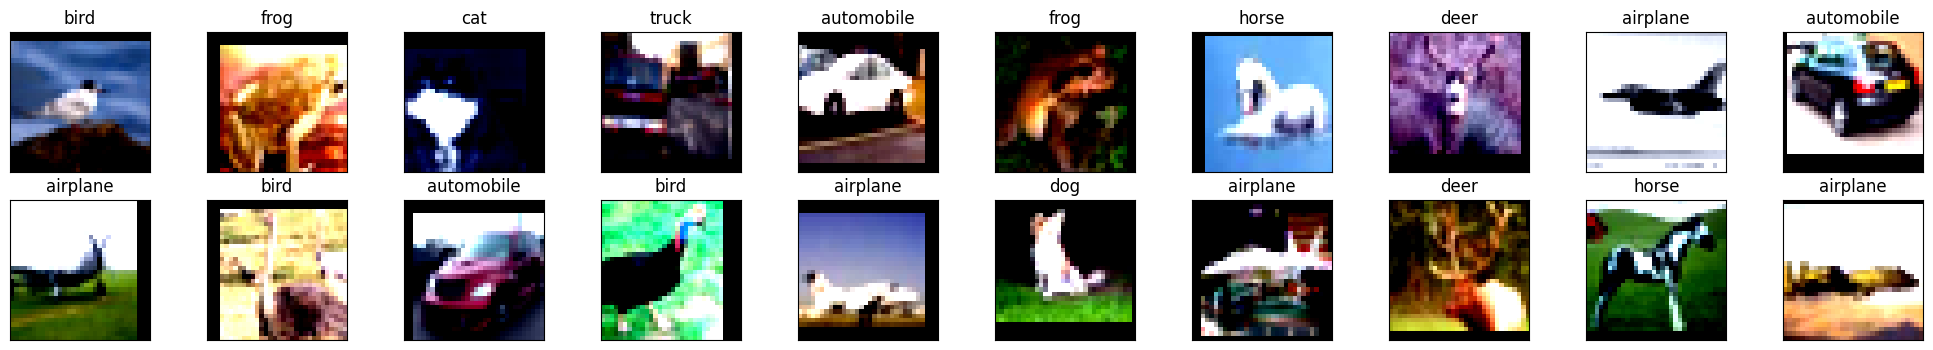

In [ ]:
# helper function to un-normalize and display an image
def imshow(img):
  img = img / 2 + 0.5  # unnormalize
  img = np.clip(img, 0, 1)
  plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# obtain one batch of training images
dataiter = iter(train_loader)
# images, labels = dataiter.next()
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
  ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])

## Resnet18 Class Structure in PyTorch

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())
    print(net)

test()


torch.Size([1, 10])
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, m

## Train

### UTILS

In [ ]:
'''Some helper functions for PyTorch, including:
    - get_mean_and_std: calculate the mean and std value of dataset.
    - msr_init: net parameter initialization.
    - progress_bar: progress bar mimic xlua.progress.
'''

def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std

def init_params(net):
    '''Init layer parameters.'''
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            init.kaiming_normal(m.weight, mode='fan_out')
            if m.bias:
                init.constant(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            init.constant(m.weight, 1)
            init.constant(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.normal(m.weight, std=1e-3)
            if m.bias:
                init.constant(m.bias, 0)




# This should work both in scripts and interactive shells
term_size = shutil.get_terminal_size(fallback=(80, 20))
term_width = term_size.columns

# _, term_width = os.popen('stty size', 'r').read().split()
term_width = int(term_width)

TOTAL_BAR_LENGTH = 65.
last_time = time.time()
begin_time = last_time

def progress_bar(current, total, msg=None):
    global last_time, begin_time
    if current == 0:
        begin_time = time.time()  # Reset for new bar.

    cur_len = int(TOTAL_BAR_LENGTH*current/total)
    rest_len = int(TOTAL_BAR_LENGTH - cur_len) - 1

    sys.stdout.write(' [')
    for i in range(cur_len):
        sys.stdout.write('=')
    sys.stdout.write('>')
    for i in range(rest_len):
        sys.stdout.write('.')
    sys.stdout.write(']')

    cur_time = time.time()
    step_time = cur_time - last_time
    last_time = cur_time
    tot_time = cur_time - begin_time

    L = []
    L.append('  Step: %s' % format_time(step_time))
    L.append(' | Tot: %s' % format_time(tot_time))
    if msg:
        L.append(' | ' + msg)

    msg = ''.join(L)
    sys.stdout.write(msg)
    for i in range(term_width-int(TOTAL_BAR_LENGTH)-len(msg)-3):
        sys.stdout.write(' ')

    # Go back to the center of the bar.
    for i in range(term_width-int(TOTAL_BAR_LENGTH/2)+2):
        sys.stdout.write('\b')
    sys.stdout.write(' %d/%d ' % (current+1, total))

    if current < total-1:
        sys.stdout.write('\r')
    else:
        sys.stdout.write('\n')
    sys.stdout.flush()

def format_time(seconds):
    days = int(seconds / 3600/24)
    seconds = seconds - days*3600*24
    hours = int(seconds / 3600)
    seconds = seconds - hours*3600
    minutes = int(seconds / 60)
    seconds = seconds - minutes*60
    secondsf = int(seconds)
    seconds = seconds - secondsf
    millis = int(seconds*1000)

    f = ''
    i = 1
    if days > 0:
        f += str(days) + 'D'
        i += 1
    if hours > 0 and i <= 2:
        f += str(hours) + 'h'
        i += 1
    if minutes > 0 and i <= 2:
        f += str(minutes) + 'm'
        i += 1
    if secondsf > 0 and i <= 2:
        f += str(secondsf) + 's'
        i += 1
    if millis > 0 and i <= 2:
        f += str(millis) + 'ms'
        i += 1
    if f == '':
        f = '0ms'
    return f

### Model Define

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device:",device)
best_acc = args.best_acc  # best test accuracy
start_epoch = args.start_epoch  # start from epoch 0 or last checkpoint epoch
# epoch = 200
# Model
print('==> Building model..')
net = ResNet18()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

# sgd
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.n_epochs)

device: cuda
==> Building model..


### Training Start

In [ ]:
# number of epochs to train the model
n_epochs = args.n_epochs

valid_loss_min = np.Inf # track change in validation loss

train_losses = []
valid_losses = []

for epoch in range(1, n_epochs+1):
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
    # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = net(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

    ######################
    # validate the model #
    ######################
    net.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
    # move tensors to GPU if CUDA is available
        if train_on_gpu:
          data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = net(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss
        valid_loss += loss.item()*data.size(0)

    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)


    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
      epoch, train_loss, valid_loss))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(net.state_dict(), 'ResNet18.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.628092 	Validation Loss: 1.273988
Validation loss decreased (inf --> 1.273988).  Saving model ...
Epoch: 2 	Training Loss: 1.122113 	Validation Loss: 0.953342
Validation loss decreased (1.273988 --> 0.953342).  Saving model ...


In [ ]:
net.load_state_dict(torch.load('ResNet18.pt'))

<All keys matched successfully>

### Train/val loss graph

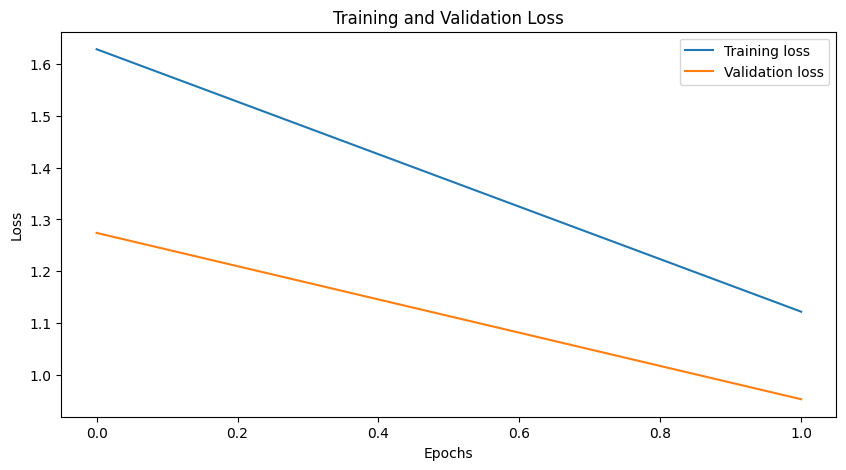

In [ ]:
# Plotting
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Test

### without label test version (professor test file)

#### load test file

In [ ]:
def load_cifar_test_nolabels(filename):
    with open(filename, 'rb') as f:
        try:
            datadict = pickle.load(f, encoding='bytes')
            # print("Data dictionary keys:", datadict.keys())  # To check the structure of the dictionary
            # Access the correct key for the data
            X = datadict[b'data']
            X = X.reshape(-1, 3, 32, 32).astype('float32')  # Adjust shape accordingly if needed
            return X
        except EOFError as e:
            print("EOFError while unpickling the file:", e)
        except Exception as e:
            print("An error occurred:", e)

test_data_path = args.test_data_path
# Loading the test batch without labels using the full path
test_data = load_cifar_test_nolabels(test_data_path)
test_dataset = CIFAR10Dataset(test_data, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

#### Run on professor's test file

In [ ]:
# Ensure the network is in evaluation mode
net.eval()

# Predictions list
predictions = []

# Iterate over test data
for batch_idx, data in enumerate(test_loader):
    # Move tensors to GPU if CUDA is available
    if train_on_gpu:
        data = data.cuda()

    # Forward pass: compute predicted outputs by passing inputs to the model
    output = net(data)

    # Convert output probabilities to predicted class
    _, pred = torch.max(output, 1)

    # Record the predictions
    predictions.append(pred.cpu().numpy())  # Move the tensor to cpu and convert to numpy

#### generate submission csv

In [ ]:
# # Concatenate all the predictions into one array
predictions = np.concatenate(predictions, axis=0)

# # You can now save the predictions to a file or use them for submission to a competition
# # Example: Saving to a CSV file
# np.savetxt("predictions.csv", predictions, delimiter=",", fmt='%d')

import csv

# Assuming 'predictions' is already a flattened list of predictions
# For the purpose of this example, let's create some dummy predictions

# Path to the CSV output file
output_file = 'submission.csv'

# Writing to CSV
with open(output_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['ID', 'Labels'])  # Writing the header

    for idx, label in enumerate(predictions):
        writer.writerow([idx, label])  # Writing each ID and its corresponding label

print(f"Submission file saved to {output_file}")

Submission file saved to submission.csv


### With label test version (test_batch)

In [ ]:
# redefine the test loader

# Function to load the test batch
def load_cifar_test_batch(filename):
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='bytes')
        X = datadict[b'data']
        Y = datadict.get(b'labels', None)  # Try to get the labels if they exist
        X = X.reshape(-1, 3, 32, 32).astype("float32")  # Reshape and convert data type
        return X, Y

# Load the test data
test_data_path = args.test_data_path

test_data, test_labels = load_cifar_test_batch(test_data_path)
if test_labels is not None:
    test_dataset = CIFAR10Dataset(test_data, test_labels, transform=transform_test)
else:
    test_dataset = CIFAR10Dataset(test_data, transform=transform_test)

test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

In [ ]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

net.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
  # move tensors to GPU if CUDA is available
  if train_on_gpu:
    data, target = data.cuda(), target.cuda()
  # forward pass: compute predicted outputs by passing inputs to the model
  output = net(data)
  # calculate the batch loss
  loss = criterion(output, target)
  # update test loss
  test_loss += loss.item()*data.size(0)
  # convert output probabilities to predicted class
  _, pred = torch.max(output, 1)
  # compare predictions to true label
  correct_tensor = pred.eq(target.data.view_as(pred))
  correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
  # calculate test accuracy for each object class
  for i in range(batch_size):
    label = target.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
  if class_total[i] > 0:
    print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
        classes[i], 100 * class_correct[i] / class_total[i],
        np.sum(class_correct[i]), np.sum(class_total[i])))
  else:
    print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.985306

Test Accuracy of airplane: 65% (659/1000)
Test Accuracy of automobile: 87% (878/1000)
Test Accuracy of  bird: 64% (641/1000)
Test Accuracy of   cat: 47% (479/1000)
Test Accuracy of  deer: 48% (485/1000)
Test Accuracy of   dog: 57% (572/1000)
Test Accuracy of  frog: 51% (514/1000)
Test Accuracy of horse: 69% (693/1000)
Test Accuracy of  ship: 81% (817/1000)
Test Accuracy of truck: 78% (783/1000)

Test Accuracy (Overall): 65% (6521/10000)
